In [33]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import trange

plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

In [3]:
from sklearn import preprocessing

In [4]:
dataset = pd.read_csv("Goulburn.csv")

In [5]:
dataset

,Date,Conductivity,PH,Turbidity,Temperature
0,2009-07-06T00:00:00.000+10:00,66.0,NaN,NaN,9.8
1,2009-07-07T00:00:00.000+10:00,66.0,6.82,9.7,9.6
2,2009-07-08T00:00:00.000+10:00,67.0,6.58,9.7,9.3
3,2009-07-09T00:00:00.000+10:00,67.0,6.63,9.3,9.2
4,2009-07-10T00:00:00.000+10:00,69.0,6.71,9.6,9.3
...,...,...,...,...,...
4296,2021-04-10T00:00:00.000+10:00,47.0,7.06,9.0,17.7
4297,2021-04-11T00:00:00.000+10:00,45.0,7.11,9.6,16.6
4298,2021-04-12T00:00:00.000+10:00,44.0,7.19,8.8,16.0
4299,2021-04-13T00:00:00.000+10:00,44.0,7.13,8.6,15.6


In [6]:
#change NA into mean 
#divide data into 30 70
#define features, target

#build model 
#train model 
#hypermeters
n_dim = 2
n_class = 2         # 2 classes, as we are doing binary classification
n_hidden = 16            # number of hidden units in each NN layer
n_hidden_layers = 1     # number of hidden layers in the NN
mlp = nn.Sequential(*(  
        [nn.Linear(n_dim, n_hidden), nn.Sigmoid()] # the first layer needs to match the input dimensions with the data
         + [nn.Linear(n_hidden, n_hidden), nn.Sigmoid()]*n_hidden_layers   # intermediate hidden layers using Sigmoid activation fn
         +[nn.Linear(n_hidden, 1)]) # the output layer maps the last hidden layer to the scalar output
                    )
losses = train(mlp, train_points, train_targets, lr=1e-3, n_it=4000)

plot_predictions(mlp, train_points, train_targets, losses)

#Find difference between ground truths and output 
-> minimize errors using lsqnonlin
#initilize parameters then update parameters from errors 
#background fn in pytorch to update parameters
#bootstrap later to use NN for each sub-dataset

SyntaxError: invalid syntax (<ipython-input-6-5e1d6d29cba3>, line 22)

In [18]:
#First, we replace NaN values with mean values of each column
dataset1 = dataset.fillna(dataset.mean())

In [19]:
#Define a function to normalize data
import statistics
def normalization(x):
    mean_x = statistics.mean(x)
    std_x = statistics.stdev(x)
    return ((x - mean_x) / std_x)

In [28]:
dataset1['PH'] = normalization(dataset1['PH'])
dataset1['Turbidity'] = normalization(dataset1['Turbidity'])
dataset1['Temperature'] = normalization(dataset1['Temperature'])
dataset1['Conductivity_norm'] = normalization(dataset1['Conductivity'])

In [60]:
ph = dataset1['PH']
turbidity = dataset1['Turbidity']
temp = dataset1['Temperature']

<AxesSubplot:ylabel='Density'>

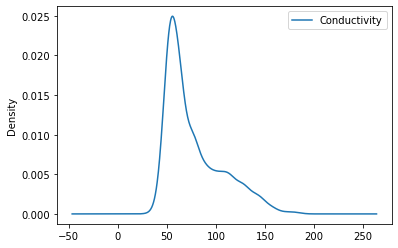

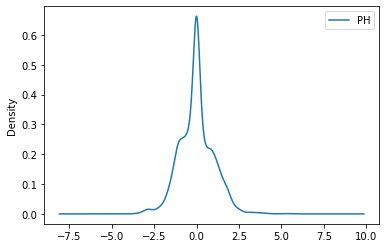

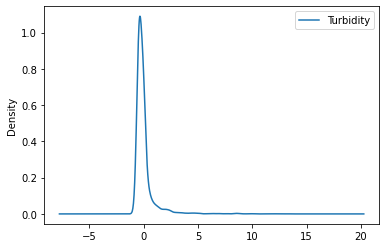

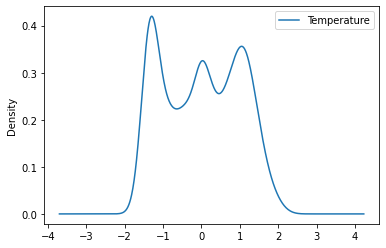

In [61]:
#Plot dataset
pd.DataFrame(dataset1['Conductivity']).plot(kind='density')
pd.DataFrame(ph).plot(kind='density')
pd.DataFrame(turbidity).plot(kind='density')
pd.DataFrame(temp).plot(kind='density')

In [57]:
#tensor is multi-dimensional matrix containing elements of a single data type
covariates = ['PH','Turbidity','Temperature']
conductivity = dataset1['Conductivity_norm']
data_points = torch.from_numpy(np.stack([dataset1[a] for a in covariates], axis=1)).float()
data_targets = torch.from_numpy(np.stack(conductivity)).float()

n_data_entries = conductivity.shape[0]
n_data_dim = len(covariates)
n_data = len(dataset1)

In [30]:
# Shuffle data
data_shuffled_idx = torch.randperm(n_data_entries).numpy()
data_targets = data_targets[data_shuffled_idx]
data_points = data_points[data_shuffled_idx]

In [31]:
# Split training and test sets
train_frac = 0.7
n_train = int(train_frac * n_data_entries)
n_test = n_data - n_train
train_points = data_points[:n_train]
train_targets = data_targets[:n_train]
test_points = data_points[n_train:]
test_targets = data_targets[n_train:]

/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


(-4.0, 6.0, -1.0, 14.0)

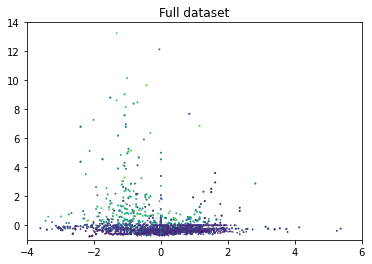

In [46]:
extent = [-4, 6, -1, 14]
plt.scatter(data_points[:, 0], data_points[:, 1], data_points[:, 2], c=data_targets)
plt.title("Full dataset")
plt.axis(extent)

/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


(-4.0, 6.0, -1.0, 14.0)

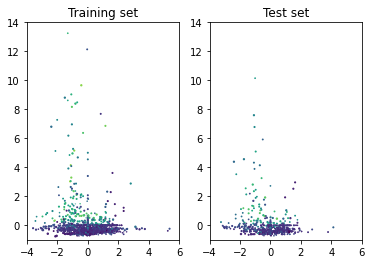

In [47]:
plt.subplot(121)
plt.scatter(train_points[:, 0], train_points[:, 1], train_points[:, 2], c=train_targets)
plt.title("Training set")
plt.axis(extent)

plt.subplot(122)
plt.scatter(test_points[:, 0], test_points[:, 1], test_points[:, 2], c=test_targets)
plt.title("Test set")
plt.axis(extent)

In [50]:
#We will use ANN-7 to predict conductivity 
# Loss Calculation with current model
def calculate_loss(model, X, y):
    number_of_examples = len(X)
    weight1, weight2 = model['w1'], model['w2']
    bias1, bias2 = model['b1'], model['b2']

    a = X.dot(weight1) + bias1
    h = np.tanh(a)
    z = h.dot(weight2) + bias2
    y_pred = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)  # softmax

    # cross entropy loss
    loss = (-1. / number_of_examples) * np.sum(np.log(y_pred[range(number_of_examples), y]))

    return loss


def predict(model, X):
    weight1, weight2 = model['w1'], model['w2']
    bias1, bias2 = model['b1'], model['b2']

    a = X.dot(weight1) + bias1
    h = np.tanh(a)
    z = h.dot(weight2) + bias2
    y_pred = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)  # softmax

    return np.argmax(y_pred, axis=1)


def build_model(X, y, nn_hdim, num_passes=20000, print_loss=False):
    model = {}
    input_dimensions = 2
    output_dimensions = 2
    # random weight assigning
    weight1 = np.random.randn(input_dimensions, nn_hdim)
    weight2 = np.random.randn(nn_hdim, output_dimensions)
    # initial biases = 0
    bias1 = np.zeros((1, nn_hdim))
    bias2 = np.zeros((1, output_dimensions))
    learning_rate = 0.02

    for i in range(num_passes):

        # prediction
        a = X.dot(weight1) + bias1
        h = np.tanh(a)
        z = h.dot(weight2) + bias2
        y_pred = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)  # softmax

        # derivatives
        # dL/dy = y_hat - y
        dLdy = y_pred
       
        # dL/da
        dLda = (1 - (np.tanh(a) * np.tanh(a))) * dLdy.dot(weight2.T)
        # dL/dWeight2
        dLdw2 = (h.T).dot(dLdy)
        # dL/dbias2
        dLdb2 = np.sum(dLdy, axis=0)
        # dL/dweight1
        dLdw1 = (X.T).dot(dLda)
        # dL/dbias1
        dLdb1 = np.sum(dLda, axis=0)

        weight1 = weight1 + (dLdw1 * (-learning_rate))
        weight2 = weight2 + (dLdw2 * (-learning_rate))
        bias1 = bias1 + (dLdb1 * (-learning_rate))
        bias2 = bias2 + (dLdb2 * (-learning_rate))

        model = {'w1': weight1, 'b1': bias1, 'w2': weight2, 'b2': bias2}

        if print_loss and i % 1000 == 0:
            print("Iteration : ", i, "Loss : ", calculate_loss(model, X, y))
    return model

In [68]:
covariates1 = [ph, turbidity, temp]
covariates1 = np.array(covariates1)
build_model(covariates1, conductivity, 1, num_passes=20000, print_loss=False)

ValueError: shapes (3,4301) and (2,1) not aligned: 4301 (dim 1) != 2 (dim 0)

In [ ]:
from scipy.optimize import least_squares
#Find residuals between output and ground truths

def residuals(out,conductivity):
    return conductivity - out

theta0 = [0, 0, 1, 2]
res3 = least_squares(residuals, theta0)